## Описание

Проект, направленный на распознавание тональности речи в аудиодорожке с помощью модели глубокого обучения Wav2Vec.

Датасеты: Toronto emotional speech set - набор из аудиодорожек с разными эмоциональными оттенками(страх, гнев, радость и.т.д);
CREMA-D - набор из фраз 91 актера разных полов и возраста, также произнесенных с разными тональностями.

**Примечание:**
Необходимо загрузить архивы с датасетами в Google Collab и раскомментить блок с распаковкой архива



## Импорт необходимых библиотек

In [1]:
import pandas as pd
import zipfile
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import torchaudio
import torch
from torch.utils.data import Dataset,DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor,Trainer,TrainingArguments,Wav2Vec2ForSequenceClassification
import warnings
warnings.filterwarnings('ignore')

In [4]:
# archive = 'archive (1).zip'
# with zipfile.ZipFile(archive, 'r') as zip_file:
#     zip_file.extractall()

## Загрузка датасета "Toronto emotional speech set"

In [7]:
paths =[]
labels = []
for dirname, _, filenames in os.walk('/content/TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname,filename))
        label=filename.split('_')[-1]
        label=label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break

print('Dataset is Loaded')

Dataset is Loaded


## Загрузка датасета "CREMA - D"

In [8]:
crema_paths = []
crema_labels = []
for dirname, _, filenames in os.walk('/content/AudioWAV'):
    for filename in filenames:
        if filename.endswith('.wav'):
            crema_paths.append(os.path.join(dirname, filename))
            label = filename.split('_')[2]
            crema_labels.append(label.lower())

In [9]:
len(paths)

2800

In [10]:
paths[:5]

['/content/TESS Toronto emotional speech set data/OAF_disgust/OAF_lose_disgust.wav',
 '/content/TESS Toronto emotional speech set data/OAF_disgust/OAF_rush_disgust.wav',
 '/content/TESS Toronto emotional speech set data/OAF_disgust/OAF_should_disgust.wav',
 '/content/TESS Toronto emotional speech set data/OAF_disgust/OAF_mess_disgust.wav',
 '/content/TESS Toronto emotional speech set data/OAF_disgust/OAF_hit_disgust.wav']

In [11]:
crema_labels[:5]

['dis', 'fea', 'dis', 'sad', 'neu']

In [12]:
labels[:5]

['disgust', 'disgust', 'disgust', 'disgust', 'disgust']

In [43]:
# Совмещение путей и лейблов двух используемых датасетов
all_paths = paths + crema_paths
all_labels = labels + crema_labels
print(f"Всего файлов: {len(all_paths)}, Всего лейблов: {len(all_labels)}")

Всего файлов: 10242, Всего лейблов: 10242


In [14]:
# Маппинг лейблов
label_mapping = {
    'sad': 'sad',
    'hap': 'happy',
    'dis': 'disgust',
    'fea': 'fear',
    'ang': 'angry',
    'neu': 'neutral'
}

# Функций для замены лейблов
def replace_labels(label):
    return label_mapping.get(label, label)

updated_labels = [replace_labels(label) for label in all_labels]

In [15]:
# Создание датафрейма
df = pd.DataFrame()
df['audio_paths'] = all_paths
df['labels'] = updated_labels
df.head()

,audio_paths,labels
0,/content/TESS Toronto emotional speech set dat...,disgust
1,/content/TESS Toronto emotional speech set dat...,disgust
2,/content/TESS Toronto emotional speech set dat...,disgust
3,/content/TESS Toronto emotional speech set dat...,disgust
4,/content/TESS Toronto emotional speech set dat...,disgust


In [16]:
df['labels'].value_counts()

,count
labels,
disgust,1671
sad,1671
happy,1671
angry,1671
fear,1671
neutral,1487
ps,400


## Кол-во данных для каждого класса

<Axes: xlabel='labels', ylabel='count'>

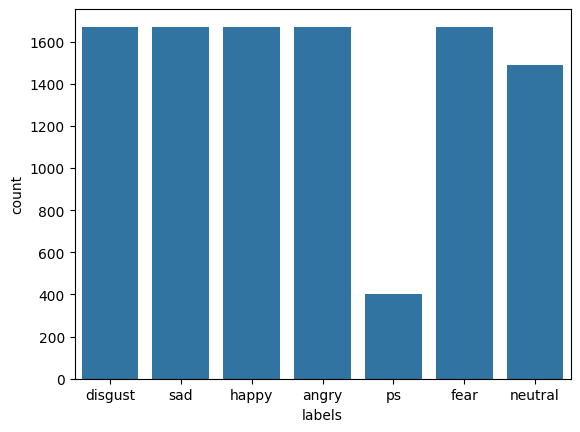

In [19]:
sns.countplot(data=df, x='labels')

In [18]:
def waveplot(data,sr,emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion,size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data,sr,emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion,size=20)
    librosa.display.specshow(xdb,sr=sr,x_axis='time',y_axis='hz')
    plt.colorbar()

## Дорожка, относящаяся к классу "Страх"

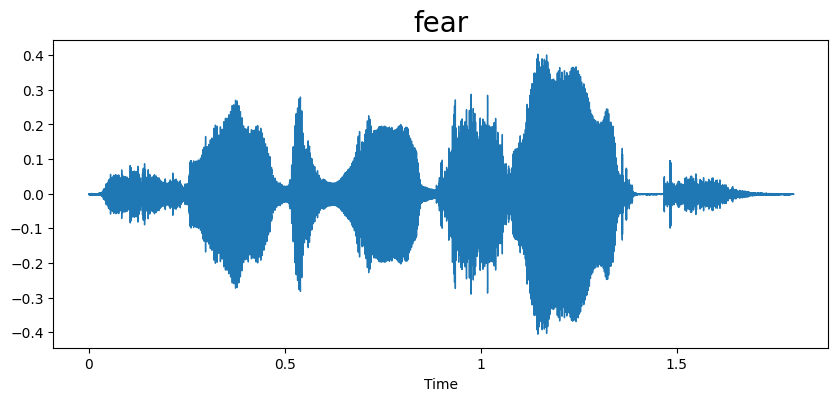

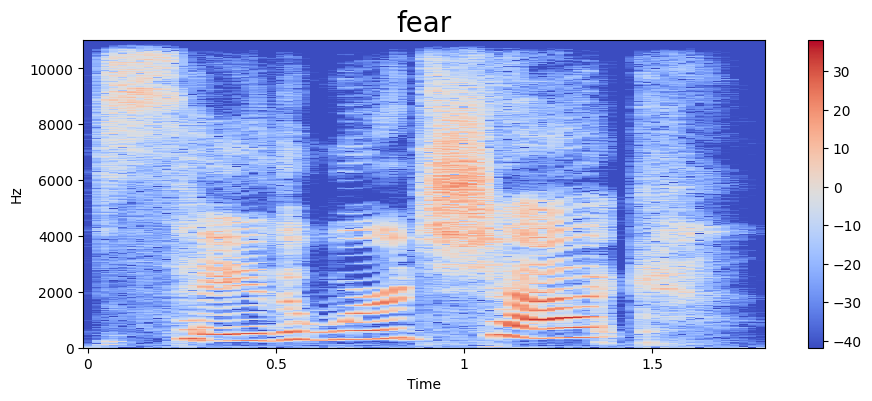

In [20]:
emotion='fear'
path=np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate=librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## Дорожка, относящаяся к классу "Злость"

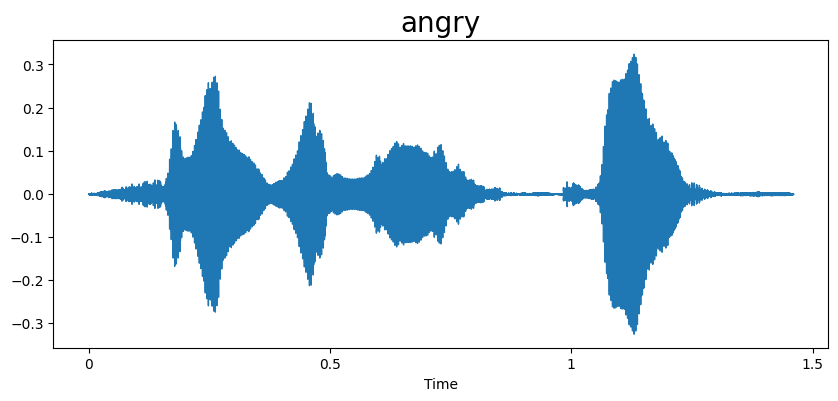

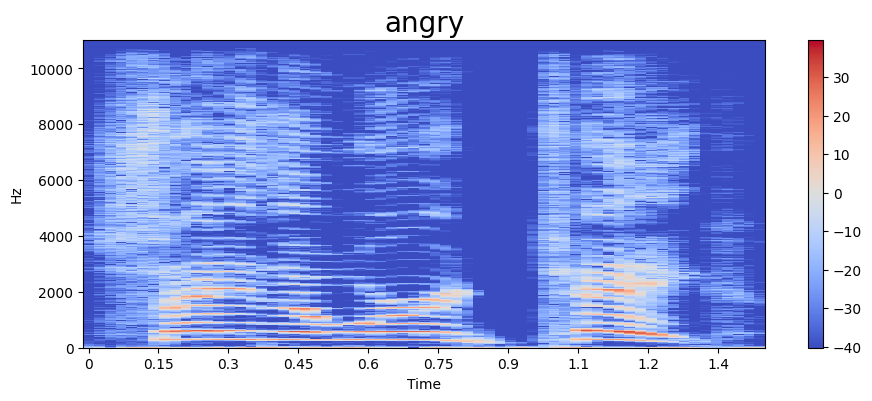

In [21]:
emotion='angry'
path=np.array(df['audio_paths'][df['labels']==emotion])[1]
data, sampling_rate=librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## Дорожка, относящаяся к классу "Отвращение"

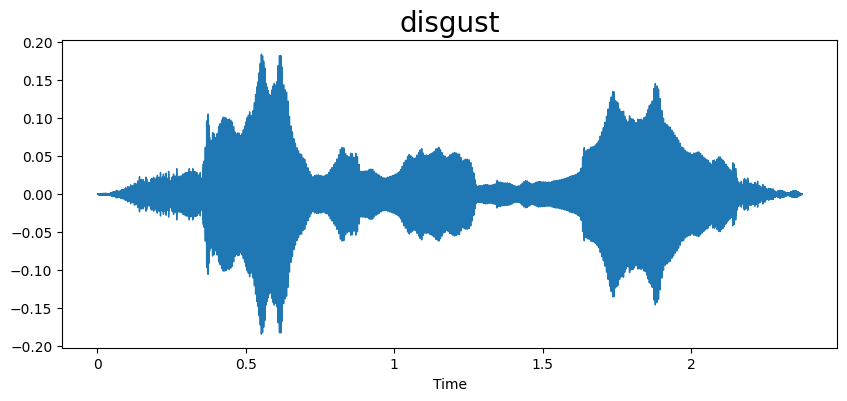

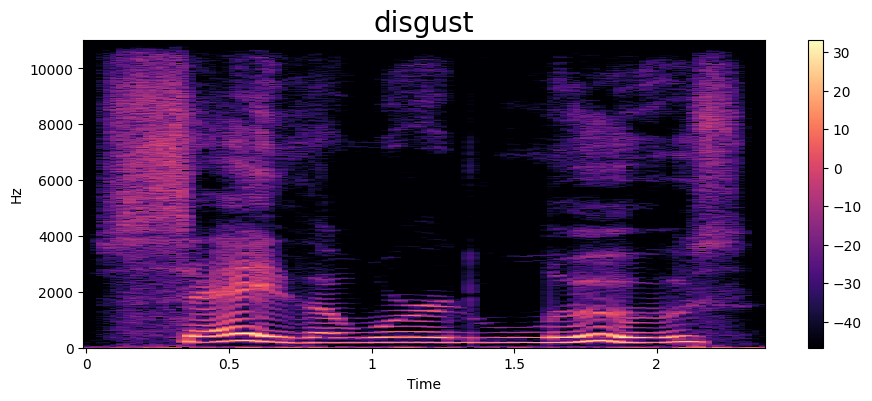

In [22]:
emotion='disgust'
path=np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate=librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## Дорожка, относящаяся к классу "Радость"

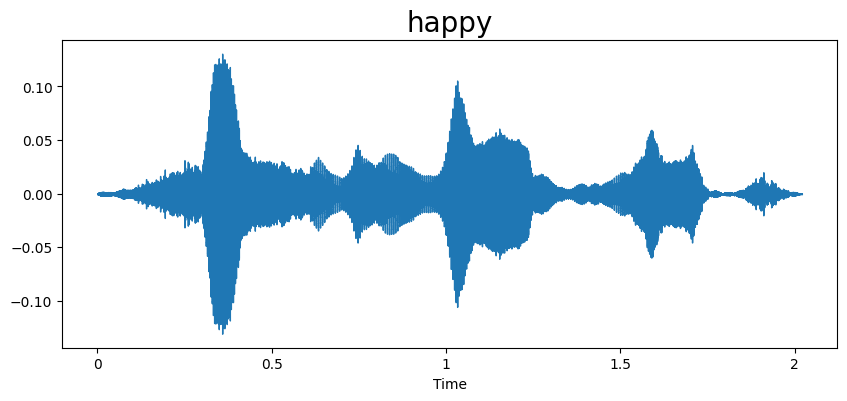

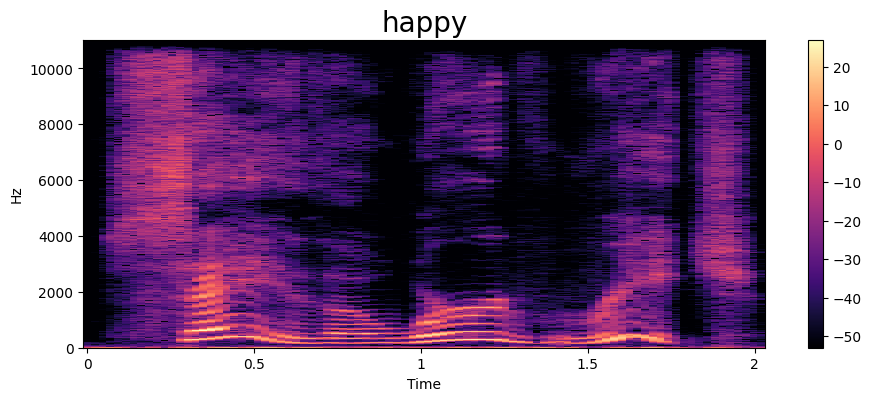

In [23]:
emotion='happy'
path=np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate=librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## Дорожка, относящаяся к классу "Грусть"

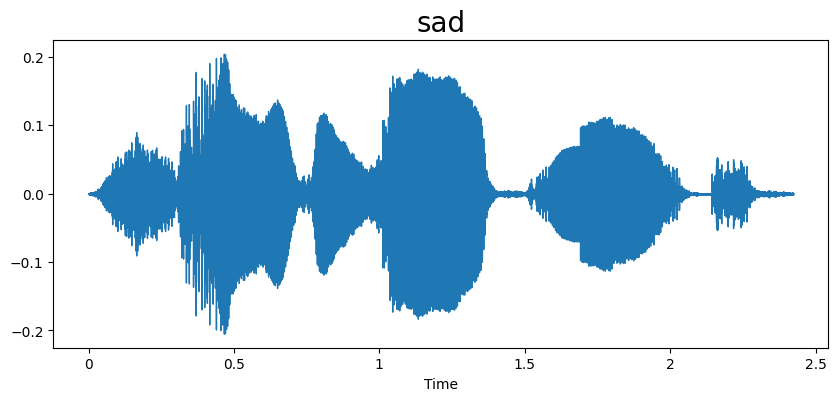

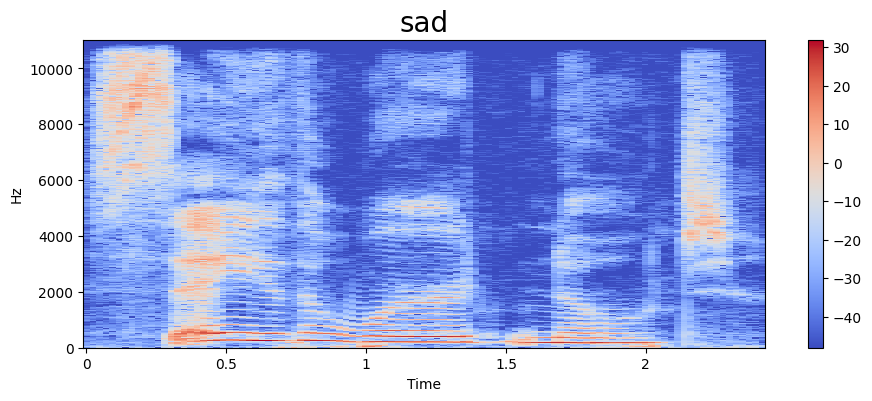

In [24]:
emotion='sad'
path=np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate=librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## Дорожка, относящаяся к классу "Нейтральный"

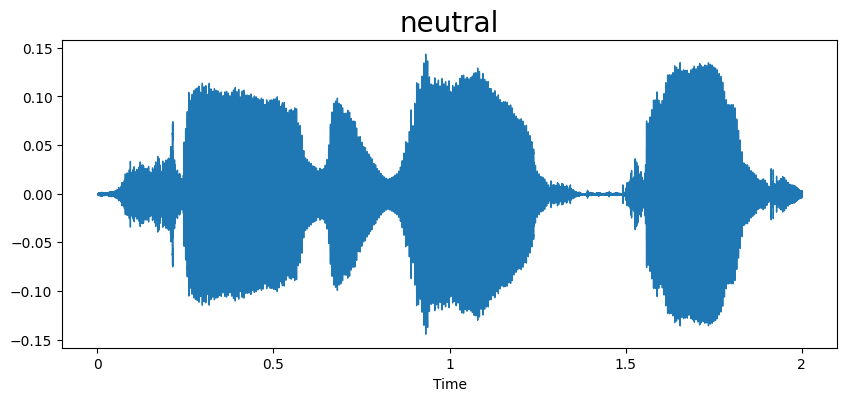

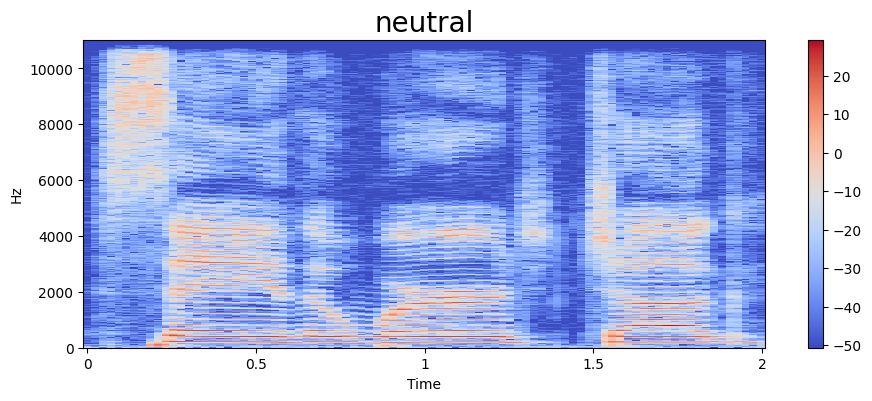

In [25]:
emotion='neutral'
path=np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate=librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## Создание класса

In [44]:
label_map = {label: idx for idx, label in enumerate(df['labels'].unique())}
inverse_label_map = {idx: label for label,idx in label_map.items()}
df['labels'] = df['labels'].map(label_map)
df.head(2)

,audio_paths,labels
0,/content/TESS Toronto emotional speech set dat...,0
1,/content/TESS Toronto emotional speech set dat...,0


In [27]:
class SpeechEmotionDataset(Dataset):
    def __init__(self,df,processor,max_length=32000):
        self.df=df
        self.processor = processor
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self,idx):
        audio_path = self.df.iloc[idx]['audio_paths']
        label=self.df.iloc[idx]['labels']

        speech, sr  = librosa.load(audio_path, sr=16000)

        if len(speech) > self.max_length:
            speech = speech[:self.max_length]
        else:
            speech = np.pad(speech,(0,self.max_length - len(speech)), 'constant')

        inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, truncate=True, max_length=self.max_length)

        input_values = inputs.input_values.squeeze()
        return {'input_values' : input_values ,'labels':torch.tensor(label, dtype=torch.long)}

In [28]:
# Разделение данных на test и test
from  sklearn.model_selection import train_test_split
train_df, test_df=train_test_split(df,test_size=0.2,random_state=42)

## Загружаем wav2vec модель

In [29]:
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
model = Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-base',num_labels=7)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
train_dataset = SpeechEmotionDataset(train_df, processor)
test_dataset = SpeechEmotionDataset(test_df, processor)

## Параметры

In [36]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=4e-5,
    per_device_train_batch_size =16,
    per_device_eval_batch_size = 16,
    num_train_epochs=15,
    weight_decay=0.01,
    report_to=[]
)

In [37]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Функция расчета метрик
def compute_metrics(pred):
    labels=pred.label_ids
    preds= np.argmax(pred.predictions,axis=1)
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds , average='weighted')
    return{
        'accuracy':accuracy,
        'precision':precision,
        'recall':recall,
        'f1':f1
    }

In [38]:
# Инициализируем Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

save_path = "/content/model.pth"

# Сохраняем модель
torch.save(model.state_dict(), save_path)

print(f"Модель сохранена по след. пути: {save_path}")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.909500,0.739805,0.738409,0.749795,0.738409,0.737571
2,0.672500,0.730791,0.742313,0.781280,0.742313,0.740480
3,0.550300,0.739996,0.752562,0.786405,0.752562,0.748708
4,0.457300,0.670946,0.790142,0.798836,0.790142,0.787266
5,0.367300,0.754767,0.782821,0.791490,0.782821,0.780387
6,0.297300,0.833478,0.778429,0.796395,0.778429,0.774831
7,0.250000,0.774897,0.810151,0.816042,0.810151,0.808227
8,0.200800,0.867231,0.813080,0.817851,0.813080,0.812162
9,0.192300,0.850703,0.804783,0.810405,0.804783,0.805399
10,0.141200,1.012754,0.814056,0.821914,0.814056,0.814228


Модель сохранена по след. пути: /content/model.pth


In [39]:
# Отображение итоговых метрик
results = trainer.evaluate()
print(results)

{'eval_loss': 1.1596357822418213, 'eval_accuracy': 0.8301610541727672, 'eval_precision': 0.8324428739651821, 'eval_recall': 0.8301610541727672, 'eval_f1': 0.8288618459381747, 'eval_runtime': 25.7965, 'eval_samples_per_second': 79.429, 'eval_steps_per_second': 5.001, 'epoch': 15.0}


# Тестируем

In [42]:
import random
# Рандомно выбираем индекс из тестового датасета
idx = random.randrange(0, len(test_dataset))

print('Исходный класс дорожки:', inverse_label_map[int(test_dataset[idx]['labels'])])

# Извлекаем входные значения для аудиосэмпла и перемещаем его на Cuda
input_values = test_dataset[idx]['input_values'].unsqueeze(0).to('cuda')

# Запускаем модель и получаем предсказания
with torch.no_grad():
    outputs = model(input_values)
logits = outputs.logits

# Получаем предсказанный класс
predicted_class = logits.argmax(dim=-1).item()
print('Предсказанный класс дорожки:', inverse_label_map[predicted_class])

# Получаем путь к нужному аудиофайлу
audio_file_path = test_dataset.df.iloc[idx]['audio_paths']

# Загрузка дорожки
audio_data, sr = librosa.load(audio_file_path, sr=16000)
Audio(audio_data, rate=sr)  # Проигрыш дорожки в google collab

Исходный класс дорожки: fear
Предсказанный класс дорожки: fear
